In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, plot_roc_curve, plot_precision_recall_curve

In [2]:
import config as conf
import data_preparation as pr
import features_extract as ex
import features_generator as fg

In [3]:
# DATA PREPARATION
train_events = conf.TRAIN_EVENTS
train_submissions = conf.TRAIN_SUBMISSIONS
test_events = conf.TEST_EVENTS
test_submissions = conf.TEST_SUBMISSIONS

In [4]:
# train_data =pr.data_preparation(train_events, train_submissions)
# test_data = pr.data_preparation(test_events, test_submissions)

In [5]:
# X_second = pd.read_csv('/Users/mitya/X_cv.csv')

In [6]:
# NEW FEATURES GENERATION

In [7]:
train_data = fg.features_generator(train_events, train_submissions)
test_data = fg.features_generator(test_events, test_submissions)

/Users/mitya/PycharmProjects/study/statistics/DS_and_ML_intro_Stepic_4852/Stepik_ML_contest/features_generator.py:13: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  users_metrics_n_days = users_metrics_n_days.merge(users_metrics_by_days, on='user_id', how='outer').fillna(0)
/Users/mitya/PycharmProjects/study/statistics/DS_and_ML_intro_Stepic_4852/Stepik_ML_contest/features_generator.py:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  users_metrics_n_days = users_metrics_n_days.merge(users_metrics_by_days, on='user_id', how='outer').fillna(0)
/Users/mitya/PycharmProjects/study/statistics/DS_and_ML_intro_Stepic_4852/Stepik_ML_contest/features_generator.py:13: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  users_metrics_n_days = use

In [8]:
# FEATURES EXTRACTION
X, y = ex.features_extract(train_data)
X_res, _ = ex.features_extract(test_data)

/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [9]:
# MODEL VALIDATION

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify=y)

In [11]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=2,
                            min_samples_leaf=10, min_samples_split=10,
                            class_weight='balanced')

rf.fit(X_train, y_train)
predictions_proba = rf.predict_proba(X_test)[:, 1]
predictions = rf.predict(X_test)

In [12]:
print('Log loss = {:.5f}'.format(log_loss(y_test, predictions_proba)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, predictions_proba)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, predictions_proba)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, predictions)))
print('Precision = {:.5f}'.format(precision_score(y_test, predictions)))
print('Recall = {:.5f}'.format(recall_score(y_test, predictions)))
print('F1 score = {:.5f}'.format(f1_score(y_test, predictions)))

print('\nClassification Report')
print(classification_report(y_test, predictions))

Log loss = 0.33829
AUC = 0.88167
Average Precision = 0.45920

Using 0.5 as threshold:
Accuracy = 0.80509
Precision = 0.31303
Recall = 0.75635
F1 score = 0.44279

Classification Report
              precision    recall  f1-score   support

       False       0.97      0.81      0.88      1727
        True       0.31      0.76      0.44       197

    accuracy                           0.81      1924
   macro avg       0.64      0.78      0.66      1924
weighted avg       0.90      0.81      0.84      1924



In [13]:
random_forest_cross_val = RandomForestClassifier(**rf.get_params())

cv_scores = cross_val_score(random_forest_cross_val, X, y, scoring='roc_auc', cv=10, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

mean score 0.8849025874768603


/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


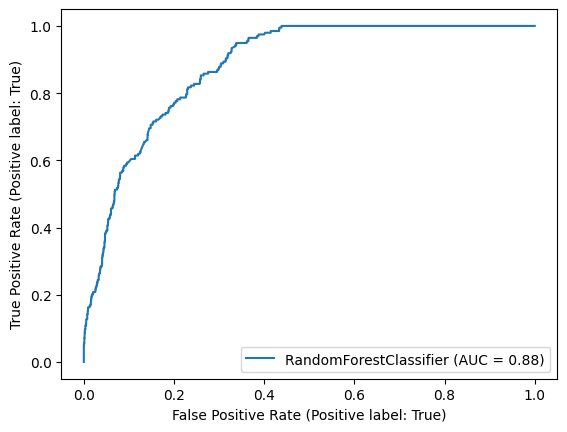

In [14]:
plot_roc_curve(rf, X_test, y_test)
plt.show()

/Users/mitya/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


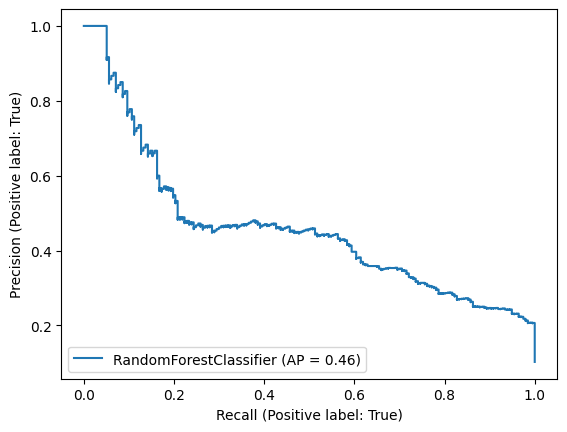

In [15]:
plot_precision_recall_curve(rf, X_test, y_test)
plt.show()

Confusion Matrix


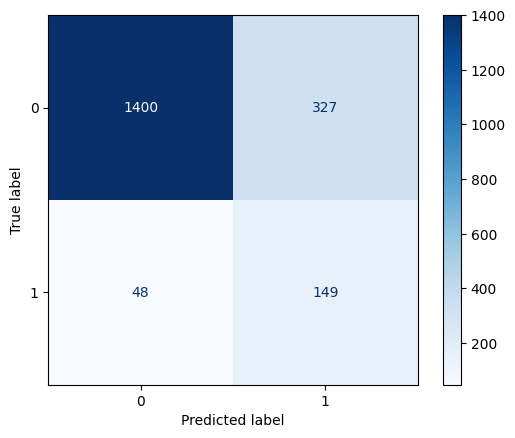

In [16]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [17]:
# PREDICTION
predictions_proba_res = rf.predict_proba(X_res)[:, 1]

In [18]:
# EXPORT DATA
result = pd.concat([pd.Series(test_data.index), pd.Series(predictions_proba_res)], axis=1).rename(columns={0: 'is_gone'}).set_index('user_id')

In [19]:
result.to_csv('/Users/mitya/prediction_res_rf.csv')

In [ ]:
# RESULT
'''
Baseline:       0.8807418373271483
Events by days: 0.8906013200243321

'''